# Expected Goals - Hvordan bliver en xG model lavet?

`Expected Goals (xG)` har i de seneste år været en meget omdiskuteret del af fodbold analyse, og er efterhånden blevet noget alle fodboldfans kender. Men xG er, som mange andre elementer i maskin læring, en "black boks". 
Hvordan kan to forskellige udbydere af xG f.eks. have henholdsvis 0.8 xG og 1.27 xG? (https://twitter.com/tapinfodbold/status/1280186019309072384)

Jeg vil der i denne artikel vise hvordan en basal xG model bliver lavet for, at give en bedre forståelse for de mange fodboldfans. Jeg gør brug af programmeringssproget `Python`. Mange bruger også `R`, men hvilket sprog der er bedst er det meget debat om. Men i det store billede gør det ikke den store forskel.

### Forbedredelse af data og enviroment

Først importerer vi de bibloteker (libraries), som vi skal gøre brug til at bygge vores model.

In [64]:
#importere bibloteker
import requests #få data gennem URL, fra internettet
import pandas as pd #bruges til at nemmere at manipulere, tilgå og opbevare vores data
import numpy as np #bruges til matematiske beregninger/manipulationer på vores data.
import matplotlib.pyplot as plt

Jeg vil gøre brug at åben `event data` fra StatsBomb, og bruge skud fra VM 2018 til at træne vores model.

In [10]:
#URl's vi vil bruge til at få adgang til vores data
base_url = "https://raw.githubusercontent.com/statsbomb/open-data/master/data/"
comp_url = base_url + "matches/{}/{}.json"
match_url = base_url + "events/{}.json"

`base_url` er den første hjemmeside hvor dataen ligger, `comp_url` er her hvor information om hver kamp ligger, såsom hvilke hold der spiller, hvilken dommer, kamp ID'et osv. `match_url` indeholder de begivenheder (events) som der skete i kampen herunder skud, afleveringer, hvis en spiller går i pres, osv.
Herefter bliver {} udfyldt med funktionen `.format()` med det givne stævne ID og Sæson ID. VM 2018 har f.eks. stævne ID 43 og Sæson ID 3.



In [11]:
#create our parse data function
def parse_data(competition_id, season_id):
    matches = requests.get(url = comp_url.format(competition_id, season_id)).json() #få alt kamp data fra den specifikke turnering
    match_ids = [match["match_id"] for match in matches] #tag alle kamp ID's fra hver kamp i turneringen
    
    #vi looper gennem listen med kamp ID's og få begivenhederne fra hver kamp
    all_events = []
    for match_id in match_ids:
        
        events = requests.get(url = match_url.format(match_id)).json() #udtrækker event data filen fra hver kamp ID
        
        shots = [x for x in events if x["type"]["name"] == "Shot"] #udtræk skud fra event dataen
        
        #vi kan nu udtrække de attributer (features) fra skudene
        for shot in shots:
            attributes = {
                "x": shot["location"][0],
                "y": shot["location"][1],
                "head": 1 if shot["shot"]["body_part"]["name"] == "Head" else 0,
                "phase": shot["shot"]["type"]["name"],
                "outcome": 1 if shot["shot"]["outcome"]["name"] == "Goal" else 0,
                "statsbomb_xg": shot["shot"]["statsbomb_xg"]
            }
            all_events.append(attributes)
        
    return pd.DataFrame(all_events)

Vi trækker først alt kamp dataen ud fra hver kamp i den specifikke turnering og sæson, hvilket i vores tilfælde er VM 2018 (43 og 3).

Herefter gør vi brug af en _list comprehension_ som looper gennem kamp dataten og laver en liste med hver kamp ID fra alle kampene. Dette kamp ID skal bruges til at udtrække event dataen, som sker i næste skridt.

Her klargør vi en tom liste som kan indeholde den event data i vores interesse, og så looper vi igennem kamp ID'erne og for hver kamp ID udtrækker vi event dataen som ligger i `match_url`.

Det gør i stand til at trække alle skudene ud af event dataen. Vi looper derefter i gennem skudene og udvælger de bestemte egenskaber ved skudene, som vi mener har indflydelse på skudet resulterer i et mål. Det er i vores tilfælde:
- `x, y koordinater`, som gør i stand til at udregne distance til mål og hvilken vinkel skudet har til målet.
- `head`, hvilket er om skudet var et hovedstød (1) eller ikke (0).
- `phase`, hvilet betegner om skudet kom efter et hjørnespark, frispark, åbent spil, osv.
- `outcome` er skudets resultat. Endte skudet med mål (1) eller ikke med mål (0).
- `statsbomb_xg`, hvilket er den xG som StatsBomb model har tilgivet skudet. Dette vil blive brugt til at sammenligne og evaluere vores model med en meget kompleks xG model.

Disse egenskaber er nu lagt ind i vores `all_events` liste og derefter retuneret i en `PandasDatFrame` som gør at vi kan manipulere og arbejde bedre med vores data.

-----------------------

Vi kan nu udtrække dataen fram VM 2018, som turnering ID 43 og sæson 3. Herefter bruger vi vores `parse_data` funktion med disse to argumenter og dataen fra VM 2018 bliver gemt i en `Pandas Dataframe` i variablen `df`.

In [12]:
competition_id = 43
season_id = 3
df = parse_data(competition_id, season_id)

In [13]:
df.shape

(1706, 6)

Dette er sådan vores de fem første rækker af vores data ser ud. Hvor vi har de forskellige features 

Vi kan nu udregne skudets distance til mål (`distance_to_goal`) og dets vinkel til mål (`goal_angle`), hvilket er to meget gode prædiktorer for om skudet ender med et mål. 

In [14]:
#funktion som udregner skudets distance til mål
def distance_to_goal(origin):
    dest = np.array([120., 40.])
    return np.sqrt(np.sum((origin - dest) ** 2))

In [15]:
#funktion som udregner skudets vinkel til mål
def goal_angle(origin):
    p0 = np.array((120., 36.))  # Left Post
    p1 = np.array(origin, dtype=np.float)
    p2 = np.array((120., 44.))  # Right Post

    v0 = p0 - p1
    v1 = p2 - p1

    angle = np.abs(np.math.atan2(np.linalg.det([v0, v1]), np.dot(v0, v1)))
    
    return angle

Disse beregninger er taget fra Devin Pleuler Soccer Analytics Handbook (https://github.com/devinpleuler/analytics-handbook).


Vi kan nu lægge disse to beregninger til vores egenskaber ved skudet og lægge som en kolonne i vores dataframe.

Vi bruger en teknik der hedder `broadcasting`, som er meget effektiv på store datasets. (https://stackoverflow.com/questions/29954263/what-does-the-term-broadcasting-mean-in-pandas-documentation)
Samtidig gør vi brug af `lambda` funktion, hvilket gør at vi ikke skal definere en helt ny funktion.

In [16]:
df['distance_to_goal'] = df.apply(lambda row: distance_to_goal(row[['x', 'y']]), axis=1)
df['goal_angle'] = df.apply(lambda r: goal_angle(r[['x', 'y']]), axis=1)

Vi fjerner herefter alle skudene som kommer fra enten straffespark eller frispark. Vi fjerner dem da da vil skævvride vores data, da vi vil forudsige chancen for at score fra åbent spil.

In [22]:
df_final = df[~df["phase"].isin(["Penalty", "Free Kick"])]
df_final["phase"].unique()

array(['Open Play'], dtype=object)

# Træning, test og evalution af vores model
Vi har ny klargjort vores data, så vores model er klar til at blive trænet.

In [23]:
from sklearn.linear_model import LogisticRegression

`Egenskaberne` (features) ved skudene som vores model skal trænes på er `distance_to_goal`, `goal_angle` og `head`, mens det vi vil fordudsige er `target`, altså mål (1) eller ikke mål (0).

In [24]:
model = LogisticRegression()
features = ["distance_to_goal", "goal_angle", "head"]
target = "outcome"
df_final[features+[target]].head()

,distance_to_goal,goal_angle,head,outcome
0,7.810250,0.726642,0,1
1,8.944272,0.785398,0,1
3,23.345235,0.251639,0,0
4,24.186773,0.325437,0,0
5,13.453624,0.411456,0,0


Vi splitter nu vores dataset ind i et `test_set` og `train_set`, og sikrer os at dataen er spillet ordentligt.

In [26]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(df_final[features+[target]], test_size=0.2)
print("train:", train.shape, "\ntest:", test.shape)

train: (1244, 4) 
test: (312, 4)


Vi __træner/fitter__ vores model på vores `train_set`.

In [51]:
fit = model.fit(train_set.loc[:, features],
                train_set.loc[:, target])

Vi kan nu få vores model til at lave en probibalistisk forudsigelse på om skudet mellem 0-1, med de givne egenskaber (features), vil resultere i et mål, altså en xG på skudet.

In [52]:
predictions = pd.DataFrame(model.predict_proba(test_set.loc[:, features]),
                           index = test_set.index,
                           columns=[0, f"{target}_prob"])

- `ìndex` vi matcher vores index fra de index fra `test_set`, fordi ellers ville vores model forudsige de forkerte skud.
- `columns` vi giver den anden kolonne et andet navn, fordi denne kolonne betegner vores model probibalistiske forudsigelse for at skudet ender med at mål, altså skudets xG. Den første kolonne er derimod den probibalistiske chance for at skudet __ikke__ ender med et mål.

Vi lægger nu vores forudsigelser til vores `test_set`, så vi hurtigt kan se hvad vores model forudsiger.

In [55]:
test_set[f"{target}_pred"] = predictions[f"{target}_prob"]
test_set.head()

,distance_to_goal,goal_angle,head,outcome,outcome_pred
1577,17.029386,0.460724,0,0,0.080614
20,29.206164,0.216391,0,0,0.023051
1296,13.152946,0.585057,0,0,0.123898
657,10.000000,0.651077,1,0,0.089754
1231,24.413111,0.190756,0,0,0.032694


Som man kan se i første kolonne har et skud med foden, 17 meter til mål og en vinkel på 0.46 i følge vores model en xG på __0.08__, eller __8%__.

Vi kan nu evaluere vores model og sammenligne den med StatsBomb komplekse xG model.

### Evaluaering og sammenligning

Først bruger vi en meget intuativ måde at evaluere vores model, nemlig `præcisionen` af vores model.

In [58]:
from sklearn.metrics import accuracy_score
accuracy_score(test_set[target], test_set[f"{target}_pred"].round(0))

0.9166666666666666

Vores model har en `præcision på 92%`, altså i 92% af test skudene forudsiger vores model at der var mål, da det faktisk var et mål og den forudsiger ikke mål, da der ikke var mål. Vores model er da sindssyg god!!

Helt så nemt er det desværre ikke. For præcision er et meget analyse redskab ved xG, da langt de fleste skud ikke ender med et mål og hvis vores model derfor bare havde gættet på at skudet ikke ender med mål vil modellens præcision være på:

In [62]:
accuracy_score(test_set[target], np.zeros(test_set[target].shape))

0.9198717948717948

Altså er vores model ikke særlig god...

Men vi kan nu lave en simpel sammenligning med StatsBomb xG model:

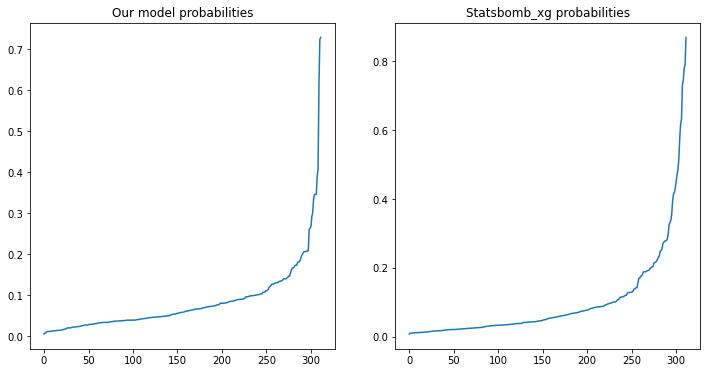

In [66]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))

ax1.plot(sorted(predictions[f"{target}_prob"]))
ax2.plot(sorted(df_final['statsbomb_xg'].sample(312)))

ax1.set_title("Our model probabilities")
ax2.set_title("Statsbomb_xg probabilities")
plt.show()